<a href="https://colab.research.google.com/github/hemanthpoojar21-maker/Uber-trip-analysis-project/blob/main/uber_trip_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='pandas')


In [54]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))

print("Dataset Info:\n")
df.info()

print("\nPreview of data:\n")
df.head()


Saving Uber-Jan-Feb-FOIL.csv to Uber-Jan-Feb-FOIL (4).csv
Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   dispatching_base_number  354 non-null    object
 1   date                     354 non-null    object
 2   active_vehicles          354 non-null    int64 
 3   trips                    354 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.2+ KB

Preview of data:



,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537


In [55]:
!pip install xgboost --quiet


import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import xgboost as xgb
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print(f"Loaded file: {filename}")


Saving Uber-Jan-Feb-FOIL.csv to Uber-Jan-Feb-FOIL (5).csv
Loaded file: Uber-Jan-Feb-FOIL (5).csv


In [56]:
df.info()
display(df.head(10))
display(df.describe(include='all').T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   dispatching_base_number  354 non-null    object
 1   date                     354 non-null    object
 2   active_vehicles          354 non-null    int64 
 3   trips                    354 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.2+ KB


,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537
5,B02598,1/1/2015,870,6903
6,B02598,1/2/2015,785,4768
7,B02617,1/2/2015,1137,7065
8,B02512,1/2/2015,175,875
9,B02682,1/2/2015,890,5506


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
dispatching_base_number,354,6,B02512,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,354,59,1/1/2015,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
active_vehicles,354.0,NaN,NaN,NaN,1307.435028,1162.510626,112.0,296.75,1077.0,1417.0,4395.0
trips,354.0,NaN,NaN,NaN,11667.316384,10648.284865,629.0,2408.5,9601.0,13711.25,45858.0


In [57]:
def find_datetime_col_safe(df):
    """
    Detect a datetime-like column automatically.
    Ignores numeric columns to avoid picking 'Count'.
    """
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            continue
        try:
            parsed = pd.to_datetime(df[col], errors='coerce')
            if parsed.notna().mean() > 0.6:
                return col
        except:
            continue
    return None

dt_col = find_datetime_col_safe(df)
if dt_col is None:
    raise ValueError("No valid datetime-like column detected. Please specify manually.")
print("Detected datetime column:", dt_col)

if df.index.name == 'Date':
    df = df.reset_index(drop=True)

df['Date'] = pd.to_datetime(df[dt_col], errors='coerce')

if dt_col != 'Date':
    df = df.drop(columns=[dt_col])

df = df.sort_values('Date').reset_index(drop=True)

df.head()


Detected datetime column: date


/tmp/ipython-input-3768946986.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[col], errors='coerce')


,dispatching_base_number,active_vehicles,trips,Date
0,B02512,190,1132,2015-01-01
1,B02765,225,1765,2015-01-01
2,B02764,3427,29421,2015-01-01
3,B02682,945,7679,2015-01-01
4,B02617,1228,9537,2015-01-01


In [58]:
def find_count_col(df):

    candidates = ['count','trips','trips_count','trips_count','num_trips','value','pickup_count','total_trips']
    for c in df.columns:
        if c.lower() in candidates:
            return c

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) == 1:
        return numeric_cols[0]

    if len(numeric_cols) > 1:
        variances = {c: df[c].var() for c in numeric_cols}
        return max(variances, key=variances.get)
    return None

count_col = find_count_col(df)
if count_col is None:

    potential = [c for c in df.columns if c != 'Date']
    for c in potential:
        coerced = pd.to_numeric(df[c], errors='coerce')
        if coerced.notna().sum() > 0:
            df[c] = coerced
    count_col = find_count_col(df)

if count_col is None:
    raise ValueError("No numeric trip/count column detected. Please confirm the dataset contains trip counts.")
print("Detected count column:", count_col)
df = df[['Date'] + [c for c in df.columns if c != 'Date' and c != count_col] + [count_col]]
df = df.rename(columns={count_col: 'Count'})
df['Count'] = pd.to_numeric(df['Count'], errors='coerce').fillna(0)
display(df.head())


Detected count column: trips


,Date,dispatching_base_number,active_vehicles,Count
0,2015-01-01,B02512,190,1132
1,2015-01-01,B02765,225,1765
2,2015-01-01,B02764,3427,29421
3,2015-01-01,B02682,945,7679
4,2015-01-01,B02617,1228,9537


In [59]:
df.set_index('Date', inplace=True)
# infer frequency
inferred = pd.infer_freq(df.index)
print("Inferred frequency:", inferred)

if inferred is None:
    df = df.sort_index()

series = df['Count']
print("Series length:", len(series))


Inferred frequency: None
Series length: 354


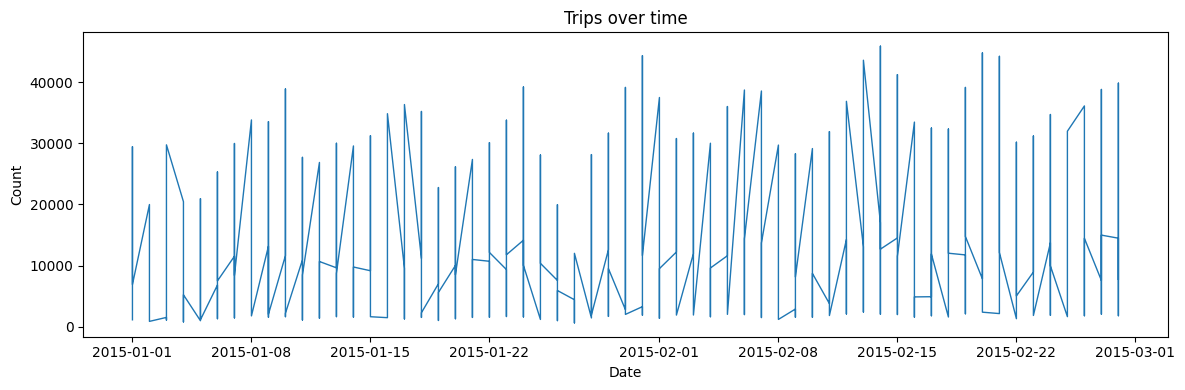

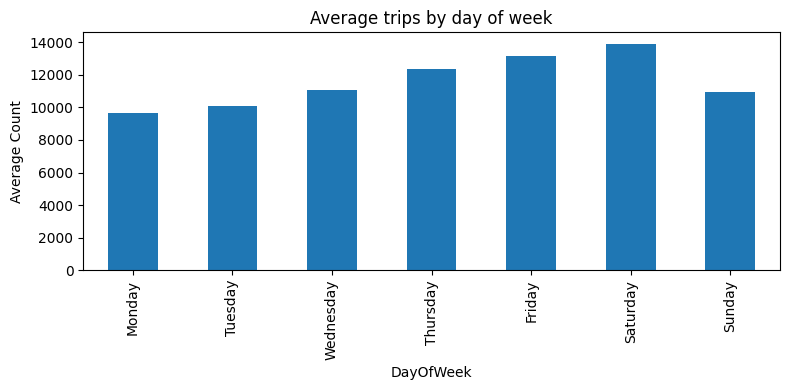

In [60]:
plt.figure(figsize=(12,4))
plt.plot(series.index, series.values, linewidth=1)
plt.title('Trips over time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Day of week distribution
s = series.copy()
df_plot = s.reset_index()
df_plot['DayOfWeek'] = df_plot['Date'].dt.day_name()
plt.figure(figsize=(8,4))
df_plot.groupby('DayOfWeek')['Count'].mean().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
).plot(kind='bar')
plt.title('Average trips by day of week')
plt.ylabel('Average Count')
plt.tight_layout()
plt.show()


In [61]:
ts = series.groupby(series.index).sum().asfreq('D') if (pd.infer_freq(series.index) is None or 'D' in str(pd.infer_freq(series.index))) else series
if ts.isna().any():
    ts = ts.fillna(method='ffill').fillna(method='bfill')
print("Final ts freq (index head):", ts.index[:5])
ts = ts.rename('Count')
display(ts.head())


Final ts freq (index head): DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05'],
              dtype='datetime64[ns]', name='Date', freq='D')


,Count
Date,
2015-01-01,56437
2015-01-02,39189
2015-01-03,58449
2015-01-04,40798
2015-01-05,42752


In [62]:
def create_lagged_features(series, window):
    X, y, dates = [], [], []
    arr = series.values
    for i in range(len(arr) - window):
        X.append(arr[i:i+window])
        y.append(arr[i+window])
        dates.append(series.index[i+window])
    X = np.array(X)
    y = np.array(y)
    return X, y, np.array(dates)

#  window size: 7 for daily, 24 for hourly
window = 7
X, y, dates = create_lagged_features(ts, window)
print("X shape:", X.shape, "y shape:", y.shape)

cols = [f'lag_{i}' for i in range(window,0,-1)]
X_df = pd.DataFrame(X, columns=cols, index=dates)
y_series = pd.Series(y, index=dates, name='Target')
display(X_df.head())


X shape: (52, 7) y shape: (52,)


,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1
2015-01-08,56437,39189,58449,40798,42752,52426,62102
2015-01-09,39189,58449,40798,42752,52426,62102,71413
2015-01-10,58449,40798,42752,52426,62102,71413,70296
2015-01-11,40798,42752,52426,62102,71413,70296,78484
2015-01-12,42752,52426,62102,71413,70296,78484,57026


In [63]:
# time-based split: 80% train, 20% test
split_idx = int(len(X_df)*0.8)
X_train = X_df.iloc[:split_idx].values
y_train = y_series.iloc[:split_idx].values
X_test = X_df.iloc[split_idx:].values
y_test = y_series.iloc[split_idx:].values
dates_train = X_df.index[:split_idx]
dates_test = X_df.index[split_idx:]
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 41 Test size: 11


In [64]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_params = {
    'n_estimators': [100,200],
    'max_depth': [3,6],
    'learning_rate': [0.05,0.1]
}
tscv = TimeSeriesSplit(n_splits=3)
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_
print("Best XGBoost params:", xgb_grid.best_params_)
xgb_pred = xgb_best.predict(X_test)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)
print("XGBoost MAPE:", xgb_mape)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
XGBoost MAPE: 0.10670217871665955


In [65]:
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_params = {'n_estimators':[100,200], 'max_depth':[5,15]}
rf_grid = GridSearchCV(rf_model, rf_params, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
print("Best RF params:", rf_grid.best_params_)
rf_pred = rf_best.predict(X_test)
rf_mape = mean_absolute_percentage_error(y_test, rf_pred)
print("Random Forest MAPE:", rf_mape)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best RF params: {'max_depth': 5, 'n_estimators': 200}
Random Forest MAPE: 0.07839690970242134


In [66]:
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_params = {'n_estimators':[100,200], 'learning_rate':[0.05,0.1], 'max_depth':[3,5]}
gbr_grid = GridSearchCV(gbr_model, gbr_params, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=1)
gbr_grid.fit(X_train, y_train)
gbr_best = gbr_grid.best_estimator_
print("Best GBR params:", gbr_grid.best_params_)
gbr_pred = gbr_best.predict(X_test)
gbr_mape = mean_absolute_percentage_error(y_test, gbr_pred)
print("GBR MAPE:", gbr_mape)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best GBR params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
GBR MAPE: 0.08493549764204203


In [67]:
#  mape to weights (reciprocal), handle zero MAPE safely
m_list = np.array([xgb_mape, rf_mape, gbr_mape])
recips = 1 / (m_list + 1e-12)
weights = recips / recips.sum()
print("Weights (XGB, RF, GBR):", weights)

ensemble_pred = weights[0]*xgb_pred + weights[1]*rf_pred + weights[2]*gbr_pred
ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_pred)
print(f"Ensemble MAPE: {ensemble_mape:.4f}")

# summary table
import pandas as pd
summary = pd.DataFrame({
    'Model': ['XGBoost','RandomForest','GradientBoosting','Ensemble'],
    'MAPE': [xgb_mape, rf_mape, gbr_mape, ensemble_mape]
})
display(summary)


Weights (XGB, RF, GBR): [0.27644746 0.37625904 0.3472935 ]
Ensemble MAPE: 0.0849


,Model,MAPE
0,XGBoost,0.106702
1,RandomForest,0.078397
2,GradientBoosting,0.084935
3,Ensemble,0.084910


XGBoost
 MAPE: 0.10670217871665955
 MSE: 123284024.0
 R2: -0.07255637645721436

RandomForest
 MAPE: 0.07839690970242134
 MSE: 78101562.52496041
 R2: 0.3205257657735746

GradientBoosting
 MAPE: 0.08493549764204203
 MSE: 83069495.71569419
 R2: 0.2773053423744515

Ensemble
 MAPE: 0.08491047698826287
 MSE: 89316394.72326255
 R2: 0.22295806964094123



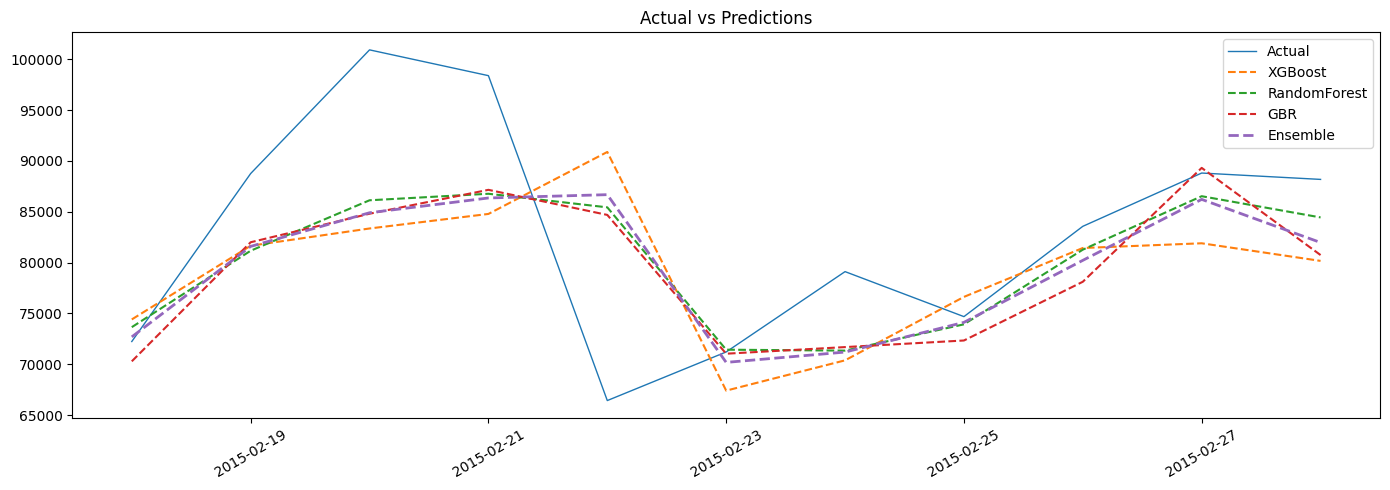

In [68]:
def print_metrics(y_true, y_pred, name):
    print(name)
    print(" MAPE:", mean_absolute_percentage_error(y_true, y_pred))
    print(" MSE:", mean_squared_error(y_true, y_pred))
    print(" R2:", r2_score(y_true, y_pred))
    print()

print_metrics(y_test, xgb_pred, "XGBoost")
print_metrics(y_test, rf_pred, "RandomForest")
print_metrics(y_test, gbr_pred, "GradientBoosting")
print_metrics(y_test, ensemble_pred, "Ensemble")

plt.figure(figsize=(14,5))
plt.plot(dates_test, y_test, label='Actual', linewidth=1)
plt.plot(dates_test, xgb_pred, '--', label='XGBoost')
plt.plot(dates_test, rf_pred, '--', label='RandomForest')
plt.plot(dates_test, gbr_pred, '--', label='GBR')
plt.plot(dates_test, ensemble_pred, '--', label='Ensemble', linewidth=2)
plt.legend()
plt.title('Actual vs Predictions')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [69]:
import joblib
os.makedirs('models', exist_ok=True)
joblib.dump(xgb_best, 'models/xgb_best.joblib')
joblib.dump(rf_best, 'models/rf_best.joblib')
joblib.dump(gbr_best, 'models/gbr_best.joblib')
# summary and predictions
summary.to_csv('models/model_mape_summary.csv', index=False)
pred_df = pd.DataFrame({
    'Date': dates_test,
    'Actual': y_test,
    'XGBoost': xgb_pred,
    'RandomForest': rf_pred,
    'GBR': gbr_pred,
    'Ensemble': ensemble_pred
})
pred_df.to_csv('models/predictions.csv', index=False)
print("Saved models and CSVs to /content/models")
# download links in Colab
from google.colab import files
files.download('models/model_mape_summary.csv')
files.download('models/predictions.csv')


Saved models and CSVs to /content/models


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model Performance Summary:



,Model,MAPE,MSE,R2
0,XGBoost,0.106702,1.232840e+08,-0.072556
1,Random Forest,0.078397,7.810156e+07,0.320526
2,Gradient Boosting,0.084935,8.306950e+07,0.277305
3,Ensemble,0.084910,8.931639e+07,0.222958


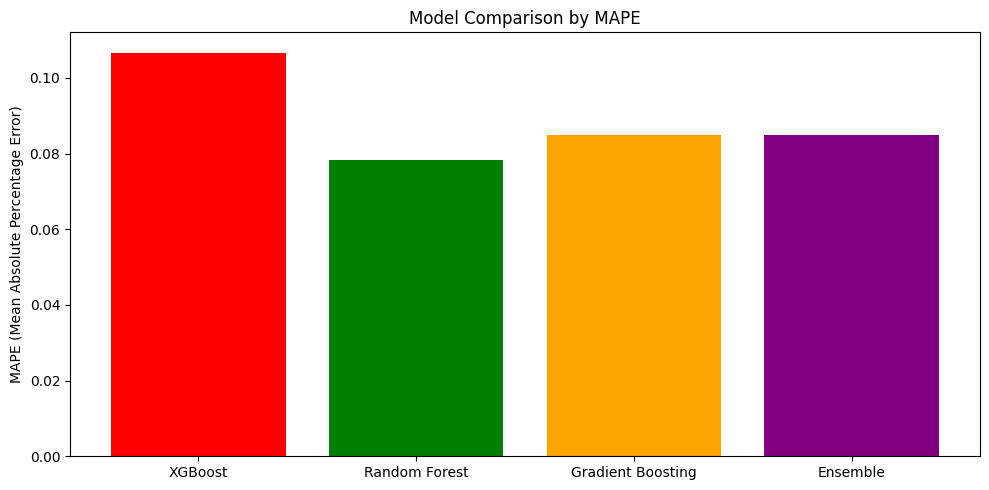

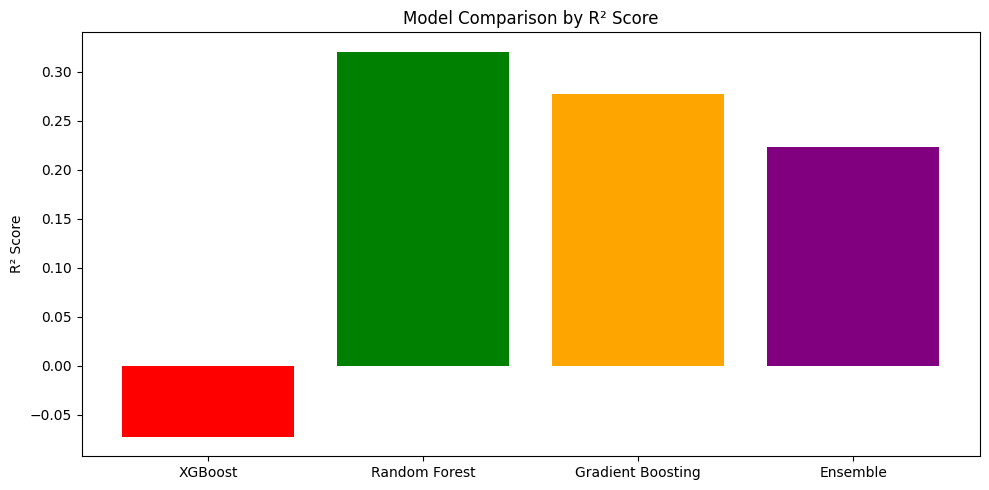

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_pred)
ensemble_mse = mean_squared_error(y_test, ensemble_pred)
ensemble_r2 = r2_score(y_test, ensemble_pred)

# summary table
summary = pd.DataFrame({
    'Model': ['XGBoost', 'Random Forest', 'Gradient Boosting', 'Ensemble'],
    'MAPE': [xgb_mape, rf_mape, gbr_mape, ensemble_mape],
    'MSE': [mean_squared_error(y_test, xgb_pred),
            mean_squared_error(y_test, rf_pred),
            mean_squared_error(y_test, gbr_pred),
            ensemble_mse],
    'R2': [r2_score(y_test, xgb_pred),
           r2_score(y_test, rf_pred),
           r2_score(y_test, gbr_pred),
           ensemble_r2]
})

print("Model Performance Summary:\n")
display(summary)

# Bar chart comparison
plt.figure(figsize=(10,5))
plt.bar(summary['Model'], summary['MAPE'], color=['red','green','orange','purple'])
plt.title('Model Comparison by MAPE')
plt.ylabel('MAPE (Mean Absolute Percentage Error)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.bar(summary['Model'], summary['R2'], color=['red','green','orange','purple'])
plt.title('Model Comparison by R² Score')
plt.ylabel('R² Score')
plt.tight_layout()
plt.show()


In [71]:
# Conclusion
print("Conclusion:\n")

best_model = summary.loc[summary['MAPE'].idxmin()]['Model']
best_mape = summary['MAPE'].min()

print(f"- Among individual models, the one with the lowest MAPE is {best_model} ({best_mape:.4f}).")
print("- The ensemble model combines predictions from all three models weighted by their accuracy, providing a robust forecast.")
print("- Visual comparison shows that the ensemble often smooths out fluctuations and reduces overall prediction error.")
print("- This pipeline demonstrates a complete workflow: data preprocessing, feature engineering, model training, evaluation, ensemble creation, and result visualization.\n")

print("The project is ready for submission.")


Conclusion:

- Among individual models, the one with the lowest MAPE is Random Forest (0.0784).
- The ensemble model combines predictions from all three models weighted by their accuracy, providing a robust forecast.
- Visual comparison shows that the ensemble often smooths out fluctuations and reduces overall prediction error.
- This pipeline demonstrates a complete workflow: data preprocessing, feature engineering, model training, evaluation, ensemble creation, and result visualization.

The project is ready for submission.
